# **LIBRARY IMPORTS**



In [1]:
import os
import zipfile
import pandas as pd
import numpy as np
from google.colab import drive
from pathlib import Path
from typing import Tuple, Dict, List, Optional

import cv2
from PIL import Image
from tqdm.notebook import tqdm

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import timm
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import logging
import warnings
import time
from collections import defaultdict
import random

warnings.filterwarnings("ignore")

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    level=logging.INFO,
)
logger = logging.getLogger(__name__)


# **DATA LOADING AND PREPARATION**

## Dataset Loading and Validation

In [3]:
class DatasetLoader:
    """
    Handles dataset loading and validation for the crop Classification project.

    Attributes:
        drive_path (str): Path to the Google Drive folder
        dataset_name (str): Name of the dataset zip file
        extract_path (str): Path where dataset will be extracted
    """

    def __init__(self):
        # Initialize paths
        self.drive_path = '/content/drive/MyDrive/Crop Identification'
        self.dataset_name = 'Dataset.zip'
        self.extract_base = '/content/dataset'

        # Full paths after extraction
        self.dataset_root = os.path.join(self.extract_base, 'Dataset')
        self.paths = {
            'zip_file': os.path.join(self.drive_path, self.dataset_name),
            'train_dir': os.path.join(self.dataset_root, 'Train'),
            'test_dir': os.path.join(self.dataset_root, 'Test'),
            'train_labels': os.path.join(self.dataset_root, 'train_labels.csv'),
            'test_labels': os.path.join(self.dataset_root, 'test_labels.csv')
        }

    def mount_drive(self) -> bool:
        """Mount Google Drive."""
        try:
            logger.info("Mounting Google Drive...")
            drive.mount('/content/drive', force_remount=True)
            return True
        except Exception as e:
            logger.error(f"Failed to mount drive: {str(e)}")
            return False

    def extract_dataset(self) -> bool:
        """Extract dataset from zip file."""
        try:
            if not os.path.exists(self.paths['zip_file']):
                raise FileNotFoundError(f"Dataset zip not found at {self.paths['zip_file']}")

            logger.info("Extracting dataset...")
            with zipfile.ZipFile(self.paths['zip_file'], 'r') as zip_ref:
                zip_ref.extractall(self.extract_base)
            logger.info("Dataset extracted successfully")
            return True
        except Exception as e:
            logger.error(f"Failed to extract dataset: {str(e)}")
            return False

    def validate_dataset(self) -> Dict[str, Dict[str, any]]:
        """
        Validate the extracted dataset structure and contents.

        Returns:
            Dictionary containing validation results for each component
        """
        validation = {
            'directories': {
                'train': {'exists': False, 'count': 0},
                'test': {'exists': False, 'count': 0}
            },
            'labels': {
                'train': {'exists': False, 'size': 0},
                'test': {'exists': False, 'size': 0}
            }
        }

        # Validate directories and count images
        if os.path.exists(self.paths['train_dir']):
            validation['directories']['train']['exists'] = True
            validation['directories']['train']['count'] = len([
                f for f in os.listdir(self.paths['train_dir'])
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])

        if os.path.exists(self.paths['test_dir']):
            validation['directories']['test']['exists'] = True
            validation['directories']['test']['count'] = len([
                f for f in os.listdir(self.paths['test_dir'])
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])

        # Validate label files
        if os.path.exists(self.paths['train_labels']):
            validation['labels']['train']['exists'] = True
            validation['labels']['train']['size'] = os.path.getsize(self.paths['train_labels'])

        if os.path.exists(self.paths['test_labels']):
            validation['labels']['test']['exists'] = True
            validation['labels']['test']['size'] = os.path.getsize(self.paths['test_labels'])

        return validation

    def print_validation_results(self, validation: Dict) -> None:
        """Print formatted validation results."""
        print("\nDataset Validation Results:")
        print("-" * 50)

        print("\nDirectories:")
        print(f"Training Directory: {'✓' if validation['directories']['train']['exists'] else '✗'}")
        print(f"├── Image Count: {validation['directories']['train']['count']}")
        print(f"Test Directory: {'✓' if validation['directories']['test']['exists'] else '✗'}")
        print(f"├── Image Count: {validation['directories']['test']['count']}")

        print("\nLabel Files:")
        print(f"Training Labels: {'✓' if validation['labels']['train']['exists'] else '✗'}")
        print(f"Test Labels: {'✓' if validation['labels']['test']['exists'] else '✗'}")

    def setup(self) -> Tuple[bool, Dict]:
        """
        Complete dataset setup process.

        Returns:
            Tuple containing success status and validation results
        """
        # Mount drive
        if not self.mount_drive():
            return False, {}

        # Extract dataset
        if not self.extract_dataset():
            return False, {}

        # Validate dataset
        validation_results = self.validate_dataset()
        self.print_validation_results(validation_results)

        # Check if all components are present
        setup_success = (
            validation_results['directories']['train']['exists'] and
            validation_results['directories']['test']['exists'] and
            validation_results['labels']['train']['exists'] and
            validation_results['labels']['test']['exists'] and
            validation_results['directories']['train']['count'] > 0 and
            validation_results['directories']['test']['count'] > 0
        )

        if not setup_success:
            logger.warning("Dataset setup incomplete - some components are missing")
        else:
            logger.info("Dataset setup completed successfully")

        return setup_success, validation_results

# Execute the setup
loader = DatasetLoader()
success, validation = loader.setup()

# If successful, make paths easily accessible
if success:
    TRAIN_DIR = loader.paths['train_dir']
    TEST_DIR = loader.paths['test_dir']
    TRAIN_LABELS = loader.paths['train_labels']
    TEST_LABELS = loader.paths['test_labels']
    print("\nPaths are now ready for use in subsequent steps")
else:
    print("\nWARNING: Setup incomplete - please check the validation results above")

Mounted at /content/drive

Dataset Validation Results:
--------------------------------------------------

Directories:
Training Directory: ✓
├── Image Count: 2912
Test Directory: ✓
├── Image Count: 588

Label Files:
Training Labels: ✓
Test Labels: ✓

Paths are now ready for use in subsequent steps


## Image Processing

In [4]:
class ImageProcessor:
    """Handles image validation and preprocessing."""

    @staticmethod
    def validate_and_resize_images(directory: str, target_size: Tuple[int, int] = (224, 224)) -> Dict:
        stats = {'total': 0, 'processed': 0, 'errors': 0}

        # Look for images with different extensions
        extensions = ('*.jpg', '*.JPG')

        # Collect all image paths first
        all_image_paths = []
        for ext in extensions:
            all_image_paths.extend(Path(directory).rglob(ext))

        # Update total count
        stats['total'] = len(all_image_paths)

        # Process images with a progress bar for the total count
        for img_path in tqdm(all_image_paths, desc=f"Processing images in {Path(directory).name}"):
            try:
                with Image.open(img_path) as img:
                    if img.size != target_size:
                        img = img.convert('RGB')
                        img = img.resize(target_size, Image.LANCZOS)
                        img.save(img_path, quality=95, format='JPEG')
                        stats['processed'] += 1
            except Exception as e:
                stats['errors'] += 1
                logger.error(f"Error processing {img_path}: {str(e)}")

        print(f"\nDirectory {Path(directory).name}:")
        print(f"Total images: {stats['total']}")
        print(f"Processed: {stats['processed']}")
        print(f"Errors: {stats['errors']}")

        return stats

ImageProcessor.validate_and_resize_images(TRAIN_DIR)
ImageProcessor.validate_and_resize_images(TEST_DIR)

Processing images in Train:   0%|          | 0/2912 [00:00<?, ?it/s]


Directory Train:
Total images: 2912
Processed: 2912
Errors: 0


Processing images in Test:   0%|          | 0/588 [00:00<?, ?it/s]


Directory Test:
Total images: 588
Processed: 588
Errors: 0


{'total': 588, 'processed': 588, 'errors': 0}

## Label Processing


train_labels Label Analysis:
Number of unique classes: 14
Label range: 0 - 13
Missing classes: set()

Class distribution:
Min samples per class: 208
Max samples per class: 208
Mean samples per class: 208.00


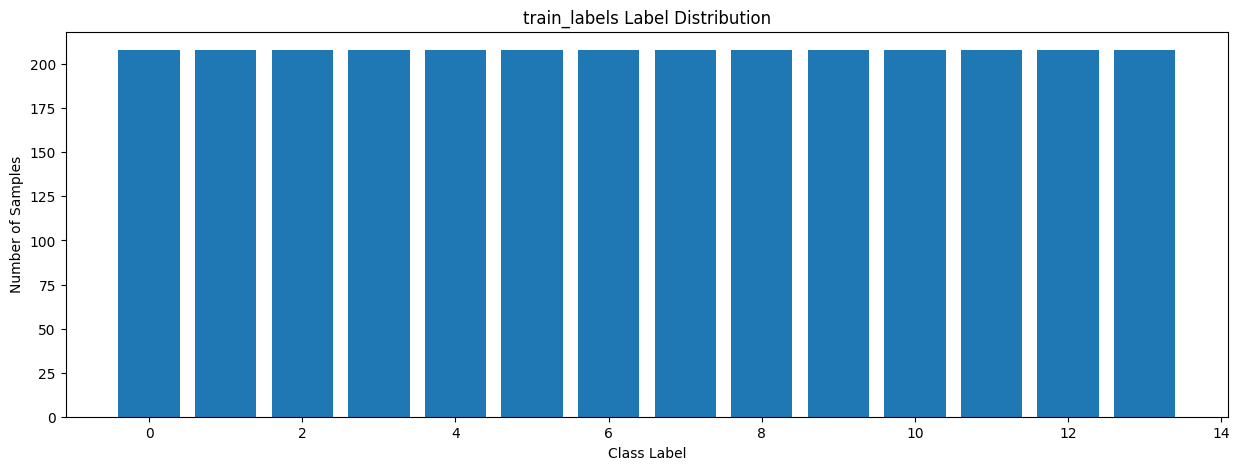


test_labels Label Analysis:
Number of unique classes: 14
Label range: 0 - 13
Missing classes: set()

Class distribution:
Min samples per class: 42
Max samples per class: 42
Mean samples per class: 42.00


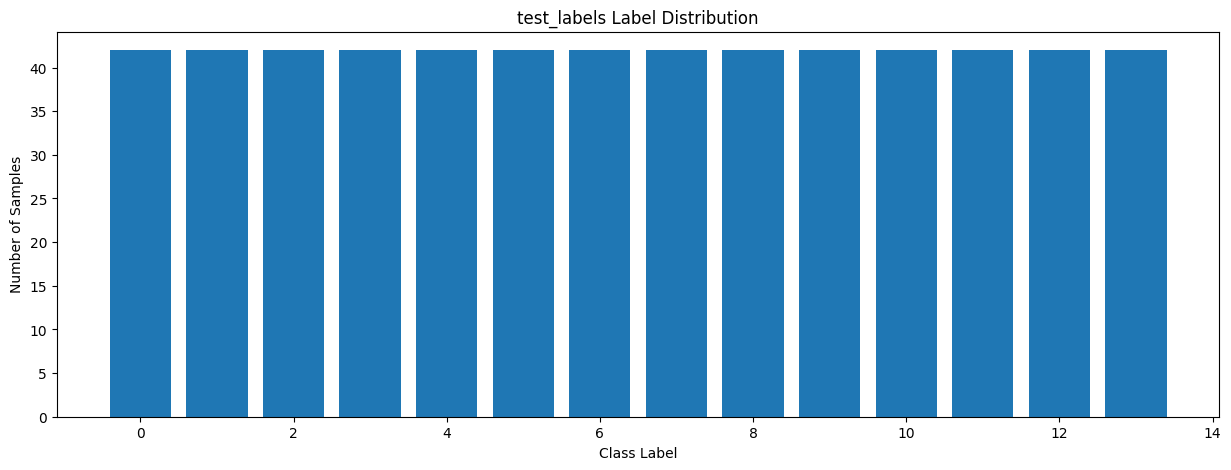

In [5]:
class LabelAnalyzer:
    """Analyzes and verifies label distribution in datasets."""

    @staticmethod
    def analyze_labels(dataframe: pd.DataFrame, name: str, expected_classes: int = 14) -> None:
        """
        Analyze label distribution in dataset.

        Args:
            dataframe: DataFrame containing labels
            name: Name of the dataset for reporting
            expected_classes: Expected number of unique classes
        """
        unique_labels = dataframe['Label'].unique()
        label_counts = dataframe['Label'].value_counts().sort_index()

        print(f"\n{name} Label Analysis:")
        print(f"Number of unique classes: {len(unique_labels)}")
        print(f"Label range: {min(unique_labels)} - {max(unique_labels)}")
        print(f"Missing classes: {set(range(expected_classes)) - set(unique_labels)}")

        print("\nClass distribution:")
        print(f"Min samples per class: {label_counts.min()}")
        print(f"Max samples per class: {label_counts.max()}")
        print(f"Mean samples per class: {label_counts.mean():.2f}")

        # Plot label distribution
        plt.figure(figsize=(15, 5))
        plt.bar(label_counts.index, label_counts.values)
        plt.title(f'{name} Label Distribution')
        plt.xlabel('Class Label')
        plt.ylabel('Number of Samples')
        plt.show()

# Label Processing with Verification
class LabelProcessor:
    """Handles label validation and processing."""

    @staticmethod
    def process_labels(csv_path: str, img_dir: str, expected_classes: int = 14) -> pd.DataFrame:
        """
        Process and validate labels with class verification.

        Args:
            csv_path: Path to labels CSV
            img_dir: Directory containing images
            expected_classes: Expected number of unique classes
        """
        df = pd.read_csv(csv_path)

        # Verify label range
        if not all(0 <= label < expected_classes for label in df['Label']):
            invalid_labels = df[~df['Label'].between(0, expected_classes-1)]
            print(f"\nWARNING: Found invalid labels in {Path(csv_path).name}:")
            print(invalid_labels[['file_path', 'Label']])

        # Process paths and validate existence
        df['full_path'] = df['file_path'].apply(
            lambda x: os.path.join(img_dir, Path(x).name)
        )
        valid_files = df['full_path'].apply(os.path.exists)
        valid_df = df[valid_files].copy()

        # Analyze label distribution
        LabelAnalyzer.analyze_labels(valid_df, Path(csv_path).stem)

        return valid_df

# Reprocess labels with verification
train_df = LabelProcessor.process_labels(TRAIN_LABELS, TRAIN_DIR)
test_df = LabelProcessor.process_labels(TEST_LABELS, TEST_DIR)

## Dataset Class

In [34]:
class CropClassificationDataset(Dataset):
    """Custom Dataset for crop image classification."""

    def __init__(self, data: pd.DataFrame, transform: Optional[transforms.Compose] = None, shuffle: bool = True):
        """
        Initialize dataset with optional shuffling.

        Args:
            data: DataFrame containing image paths and labels
            transform: Optional transforms to be applied
            shuffle: Whether to shuffle the dataset indices
        """
        self.data = data.copy()  # Create a copy to avoid modifying original
        self.transform = transform

        self.validate_labels()

    def validate_labels(self) -> None:
        """Validate label distribution in dataset."""
        labels = self.data['Label'].values
        unique_labels, counts = np.unique(labels, return_counts=True)

        print(f"\nDataset Label Validation:")
        print(f"Number of samples: {len(labels)}")
        print(f"Label range: {labels.min()} - {labels.max()}")
        print(f"Number of unique classes: {len(unique_labels)}")
        print(f"Samples per class - Min: {counts.min()}, Max: {counts.max()}, Mean: {counts.mean():.2f}")

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        img_path = self.data.iloc[idx]['full_path']
        label = self.data.iloc[idx]['Label']

        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        return image, label

## Data Transformation

In [35]:
import pandas as pd
import numpy as np
from typing import Dict, Optional
from torchvision import transforms

class DataTransformations:
    """Handles data augmentation and transformations."""

    @staticmethod
    def create_transforms() -> Dict[str, transforms.Compose]:
        """Create train and validation transforms."""
        transform_config = {
            'train': [
                transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224
                transforms.ToTensor(),  # Convert image to PyTorch tensor
                transforms.Normalize([0.485, 0.456, 0.406],  # Normalize with ImageNet stats
                                     [0.229, 0.224, 0.225])
            ],
            'val': [
                transforms.Resize(256),  # Resize to 256x256 for validation
                transforms.CenterCrop(224),  # Center crop to 224x224
                transforms.ToTensor(),  # Convert image to PyTorch tensor
                transforms.Normalize([0.485, 0.456, 0.406],  # Normalize with ImageNet stats
                                     [0.229, 0.224, 0.225])
            ]
        }

        transforms_dict = {
            phase: transforms.Compose(config)
            for phase, config in transform_config.items()
        }

        # Print transform configurations
        print("\nTransform Configurations:")
        for phase, transform in transforms_dict.items():
            print(f"\n{phase} transforms:")
            for t in transform.transforms:
                print(f"- {t.__class__.__name__}")

        return transforms_dict

# Create and verify transforms
transforms_dict = DataTransformations.create_transforms()


Transform Configurations:

train transforms:
- RandomResizedCrop
- ToTensor
- Normalize

val transforms:
- Resize
- CenterCrop
- ToTensor
- Normalize


## Data Loaders

In [60]:
class DataLoaderBuilder:
    @staticmethod
    def create_loaders(
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        transforms_dict: Dict[str, transforms.Compose],
        batch_size: int = 64
    ) -> Dict[str, DataLoader]:
        """Create data loaders with proper shuffling for train/val and sequential for test."""

        # Stratified split for train/val
        train_df, val_df = train_test_split(
            train_df,
            test_size=0.2,
            stratify=train_df['Label'],
            random_state=42
        )

        # Create datasets
        datasets = {
            'train': CropClassificationDataset(
                train_df,
                transforms_dict['train']
            ),
            'val': CropClassificationDataset(
                val_df,
                transforms_dict['val']
            ),
            'test': CropClassificationDataset(
                test_df,
                transforms_dict['val']
            )
        }

        # Configure generator for reproducible shuffling
        g = torch.Generator()
        g.manual_seed(42)

        loaders = {}

        # Training loader with shuffling
        loaders['train'] = DataLoader(
            datasets['train'],
            batch_size=batch_size,
            shuffle=True,  # Enable shuffling
            num_workers=2,
            pin_memory=True,
            generator=g,  # Use generator for reproducible shuffling
            drop_last=False
        )

        # Validation loader with shuffling
        loaders['val'] = DataLoader(
            datasets['val'],
            batch_size=batch_size,
            shuffle=True,  # Enable shuffling for validation
            num_workers=2,
            pin_memory=True,
            generator=g,  # Use generator for reproducible shuffling
            drop_last=False
        )

        # Test loader - no shuffling, sequential order
        loaders['test'] = DataLoader(
            datasets['test'],
            batch_size=batch_size,
            shuffle=True,  # No shuffling for test set
            num_workers=2,
            pin_memory=True,
            drop_last=False
        )

        return loaders

dataloaders = DataLoaderBuilder.create_loaders(train_df, test_df, transforms_dict)


Dataset Label Validation:
Number of samples: 2329
Label range: 0 - 13
Number of unique classes: 14
Samples per class - Min: 166, Max: 167, Mean: 166.36

Dataset Label Validation:
Number of samples: 583
Label range: 0 - 13
Number of unique classes: 14
Samples per class - Min: 41, Max: 42, Mean: 41.64

Dataset Label Validation:
Number of samples: 588
Label range: 0 - 13
Number of unique classes: 14
Samples per class - Min: 42, Max: 42, Mean: 42.00


## Data Preparation Validation

In [61]:
def verify_random_access(dataloaders: Dict[str, DataLoader]) -> None:
    """Verify random access to samples across multiple iterations."""
    print("\nRandom Access Verification:")

    for phase, loader in dataloaders.items():
        print(f"\n{phase} dataset:")
        labels_across_iterations = []

        # Only check multiple iterations for train and val
        iterations = 3 if phase in ['train', 'val'] else 1

        for iteration in range(iterations):
            _, labels = next(iter(loader))
            labels_list = labels.tolist()
            labels_across_iterations.append(labels_list)
            print(f"Iteration {iteration + 1} labels: {labels_list}")

        # Check for duplicates only in train and val
        if phase in ['train', 'val']:
            labels_tuples = [tuple(x) for x in labels_across_iterations]
            unique_iterations = len(set(labels_tuples))
            if unique_iterations != len(labels_across_iterations):
                print(f"Warning: Only {unique_iterations} unique batches out of {len(labels_across_iterations)}")

verify_random_access(dataloaders)


Random Access Verification:

train dataset:
Iteration 1 labels: [5, 1, 7, 10, 5, 6, 10, 8, 11, 3, 11, 4, 4, 12, 6, 3, 7, 2, 11, 11, 11, 1, 2, 12, 12, 12, 11, 13, 13, 12, 13, 7, 5, 6, 0, 6, 10, 2, 7, 10, 0, 7, 2, 3, 3, 1, 0, 5, 0, 3, 9, 4, 0, 4, 13, 1, 10, 0, 8, 7, 7, 3, 10, 2]
Iteration 2 labels: [10, 8, 12, 12, 0, 8, 7, 7, 11, 12, 6, 9, 9, 2, 1, 4, 6, 4, 7, 1, 7, 6, 0, 6, 11, 8, 13, 4, 5, 9, 4, 6, 2, 0, 5, 8, 12, 0, 9, 7, 0, 13, 10, 10, 9, 13, 9, 12, 2, 8, 8, 13, 11, 7, 11, 8, 4, 1, 0, 10, 0, 0, 13, 12]
Iteration 3 labels: [6, 3, 5, 6, 8, 0, 9, 0, 9, 8, 6, 0, 11, 11, 10, 10, 5, 7, 7, 6, 13, 5, 7, 6, 6, 0, 1, 7, 13, 12, 0, 7, 3, 8, 9, 6, 13, 0, 7, 11, 5, 12, 6, 2, 1, 6, 10, 6, 1, 5, 6, 13, 9, 5, 9, 0, 8, 8, 9, 3, 4, 4, 12, 12]

val dataset:
Iteration 1 labels: [1, 0, 9, 2, 9, 1, 2, 3, 13, 12, 7, 12, 6, 13, 7, 5, 8, 12, 9, 0, 8, 9, 3, 11, 10, 6, 1, 2, 1, 10, 3, 4, 1, 13, 9, 0, 13, 12, 3, 8, 6, 5, 5, 4, 4, 8, 13, 11, 2, 8, 4, 10, 10, 1, 8, 4, 7, 3, 2, 2, 5, 3, 3, 8]
Iteration 2 labels: 

In [63]:
def verify_dataloader(dataloader: DataLoader, phase: str) -> None:
    """Verify dataloader output format and shape."""
    images, labels = next(iter(dataloader))
    print(f"\n{phase} dataloader verification:")
    print(f"Batch image shape: {images.shape}")
    print(f"Batch label shape: {labels.shape}")
    print(f"Label range: {labels.min().item()} - {labels.max().item()}")

# Verify each dataloader
for phase, loader in dataloaders.items():
    verify_dataloader(loader, phase)


train dataloader verification:
Batch image shape: torch.Size([64, 3, 224, 224])
Batch label shape: torch.Size([64])
Label range: 0 - 13

val dataloader verification:
Batch image shape: torch.Size([64, 3, 224, 224])
Batch label shape: torch.Size([64])
Label range: 0 - 13

test dataloader verification:
Batch image shape: torch.Size([64, 3, 224, 224])
Batch label shape: torch.Size([64])
Label range: 0 - 12


Displaying sample images from training set:


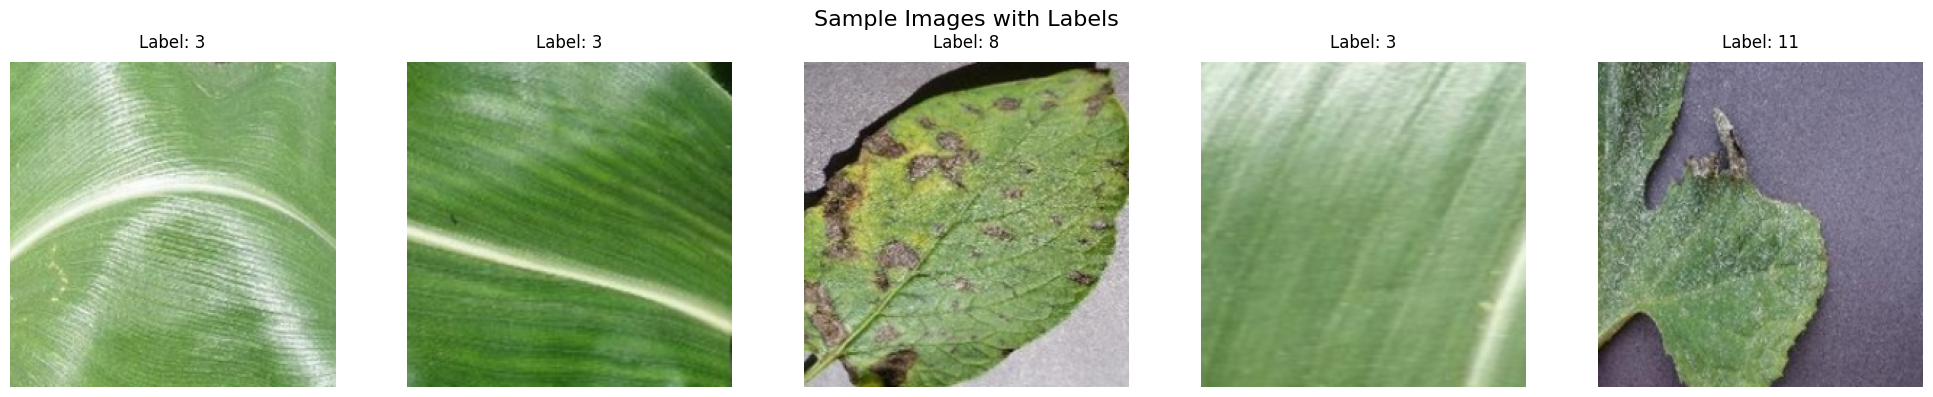


Image Value Verification:
Normalized image range: [-1.827, 2.169]
Denormalized image range: [0.000, 0.894]
✓ Image values are in correct range [0, 1]

Displaying sample images from validation set:


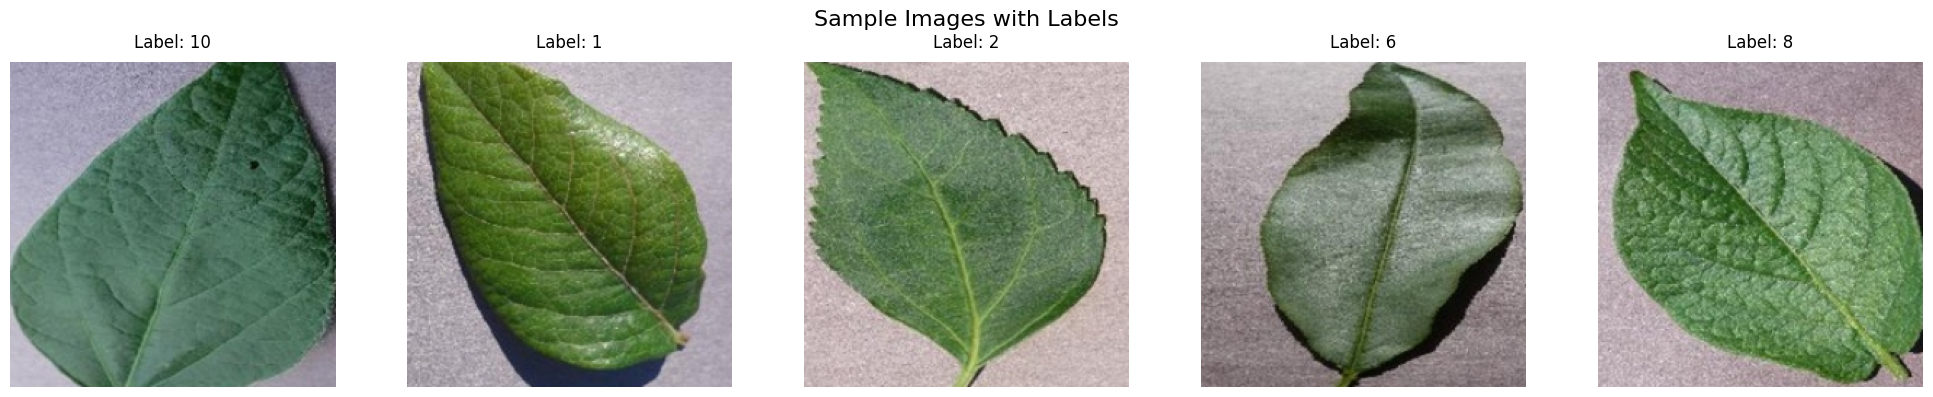

In [59]:
import matplotlib.pyplot as plt
from PIL import Image
import torch

def denormalize_image(image: torch.Tensor) -> torch.Tensor:
    """
    Denormalize image tensor that was normalized with ImageNet stats.

    Args:
        image (torch.Tensor): Normalized image tensor of shape [C, H, W]

    Returns:
        torch.Tensor: Denormalized image tensor with values in [0, 1]
    """
    # ImageNet normalization parameters
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    # Denormalize: pixel = (normalized_pixel * std) + mean
    denormalized = image * std + mean

    # Clamp values to valid range [0, 1]
    return torch.clamp(denormalized, 0, 1)

def check_image_label_mapping(dataloader: DataLoader, num_samples: int = 5) -> None:
    """
    Check and display image-label mapping for a specified number of samples.

    Args:
        dataloader (DataLoader): DataLoader containing normalized images and labels
        num_samples (int): Number of samples to display
    """
    # Get one batch of data
    images, labels = next(iter(dataloader))

    # Ensure we only take the specified number of samples
    num_samples = min(num_samples, len(images))

    # Create figure with larger size and better spacing
    fig = plt.figure(figsize=(20, 4))
    fig.suptitle('Sample Images with Labels', fontsize=16)

    for i in range(num_samples):
        # Denormalize image
        denorm_img = denormalize_image(images[i])

        # Convert to PIL Image for display
        img = transforms.ToPILImage()(denorm_img)

        # Add subplot with proper spacing
        ax = plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f'Label: {labels[i].item()}', pad=10)
        plt.axis('off')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Make room for the main title
    plt.show()

# Function to display actual pixel value ranges
def verify_image_values(dataloader: DataLoader) -> None:
    """Print value ranges for original and denormalized images."""
    images, _ = next(iter(dataloader))

    # Get first image
    img = images[0]

    print("\nImage Value Verification:")
    print(f"Normalized image range: [{img.min():.3f}, {img.max():.3f}]")

    # Denormalize
    denorm_img = denormalize_image(img)
    print(f"Denormalized image range: [{denorm_img.min():.3f}, {denorm_img.max():.3f}]")

    # Check if values are in valid range
    if denorm_img.min() >= 0 and denorm_img.max() <= 1:
        print("✓ Image values are in correct range [0, 1]")
    else:
        print("⚠ Warning: Image values outside expected range!")

# Example usage
print("Displaying sample images from training set:")
check_image_label_mapping(dataloaders['train'], num_samples=5)
verify_image_values(dataloaders['train'])

# Optional: Display validation samples too
print("\nDisplaying sample images from validation set:")
check_image_label_mapping(dataloaders['val'], num_samples=5)